<a href="https://colab.research.google.com/github/chornamarta/ml3.0/blob/main/Bank_Marketing_(Mid_term_Project)_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [223]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import scipy.stats as stats
import shap

In [2]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('bank-additional-full.csv',sep=';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.shape

(41188, 21)

In [6]:
df.isna().sum().sort_values(ascending=False)

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [7]:
categorical_cols = [c for c in df.columns if c!='y' and df[c].dtype == 'object']

In [8]:
for c in categorical_cols:
  print(f"column: \n", df[c].value_counts(),"\n")

column: 
 job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64 

column: 
 marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64 

column: 
 education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64 

column: 
 default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64 

column: 
 housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64 

column: 
 loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int6

In [9]:
df['y'].value_counts() #значно переважає один клас

,count
y,
no,36548
yes,4640


# EDA

### Опис числових змінних

In [10]:
numeric_cols = [c for c in df.columns if df[c].dtype != 'object' and c!='duration']

In [11]:
numeric_cols

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

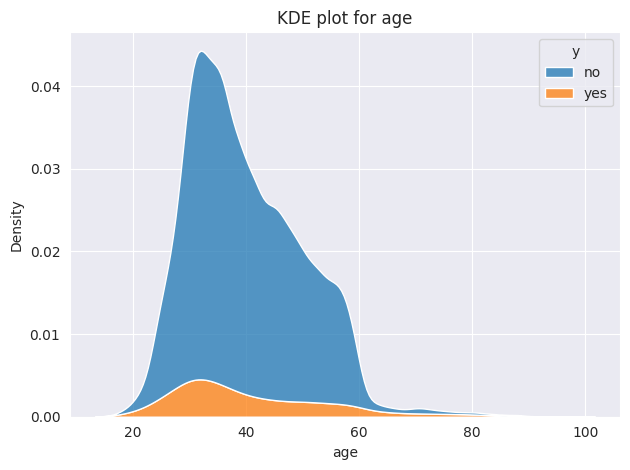

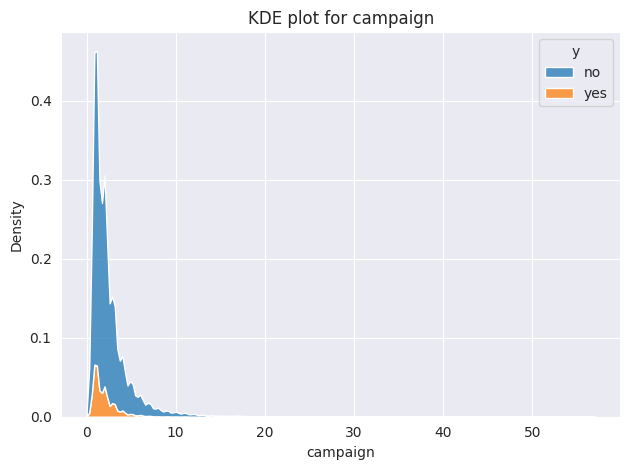

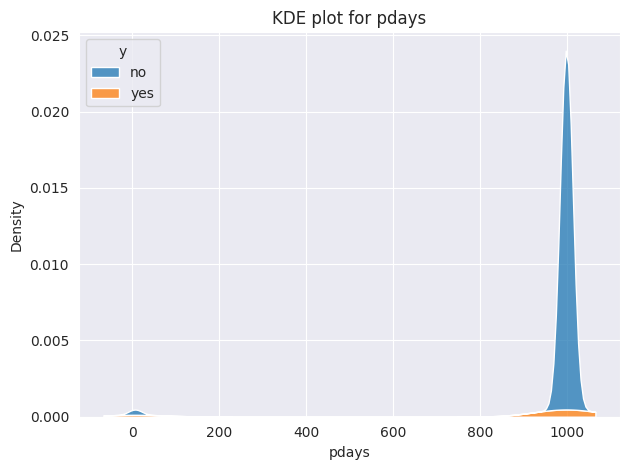

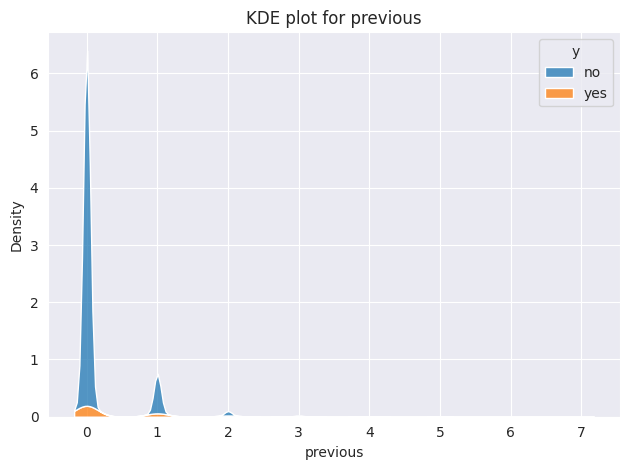

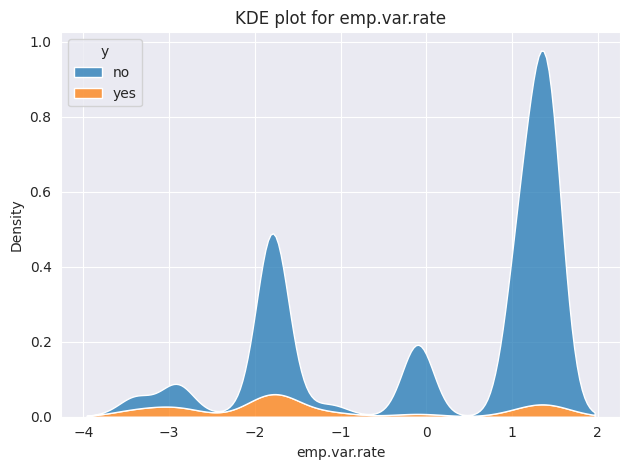

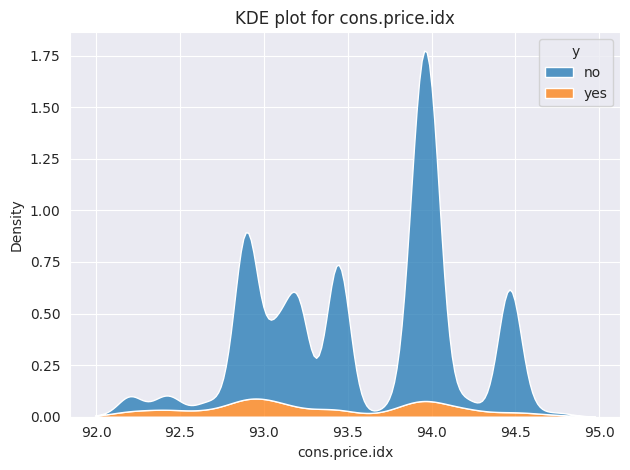

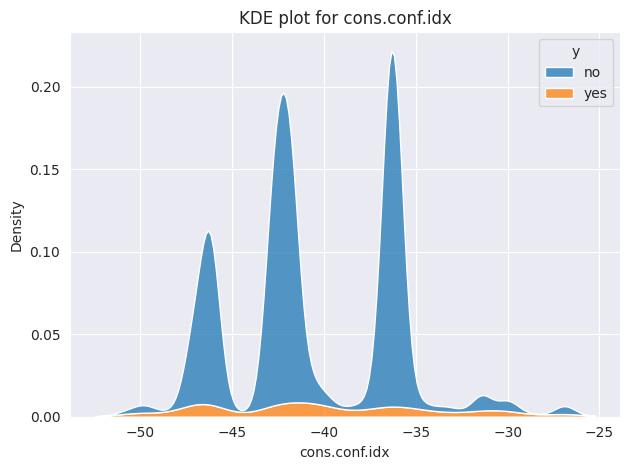

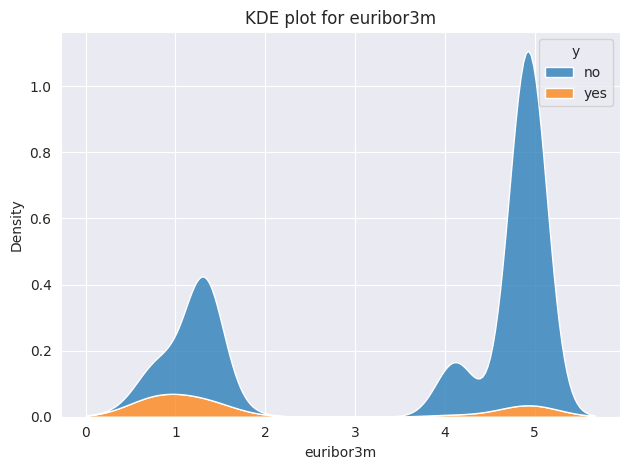

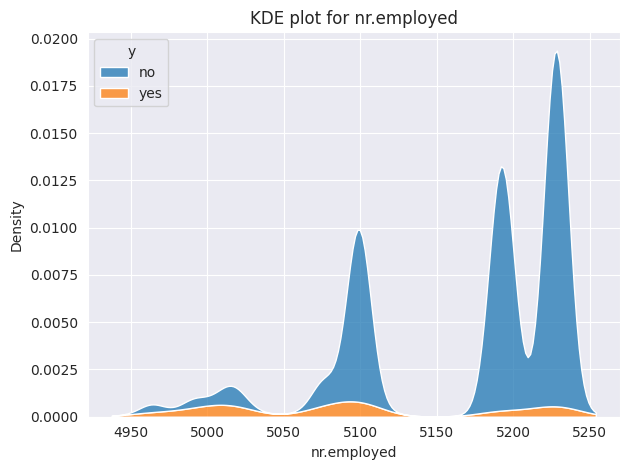

In [12]:
for c in numeric_cols:
  sns.kdeplot(data=df,x=c,hue='y',multiple="stack")
  plt.title(f'KDE plot for {c}')
  plt.tight_layout()
  plt.show()



*   Змінна `cons.conf.idx`,`campaign`,`previous` має викиди,
*   Змінна `pdays` має дуже цікавий розподіл, оскільки число 999 є сталим при ситуації "не контактували" - є сенс перетворити на бінарну змінну був контакт чи ні
* Також змінні `campaign` і `previous` показують, що чимбільше контактів з людиною тим менша ймовірність на підписання депозиту



змінна `duration` дає по суті вже відповідь на запитання, тому вона трохи невдала для навчання моделей

### Опис категоріальних змінних

In [13]:
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

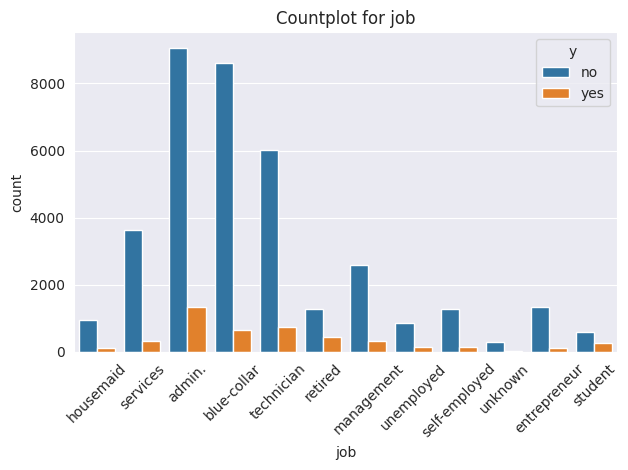

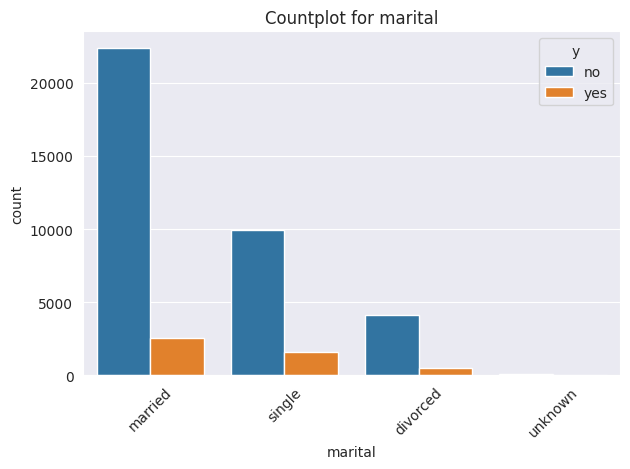

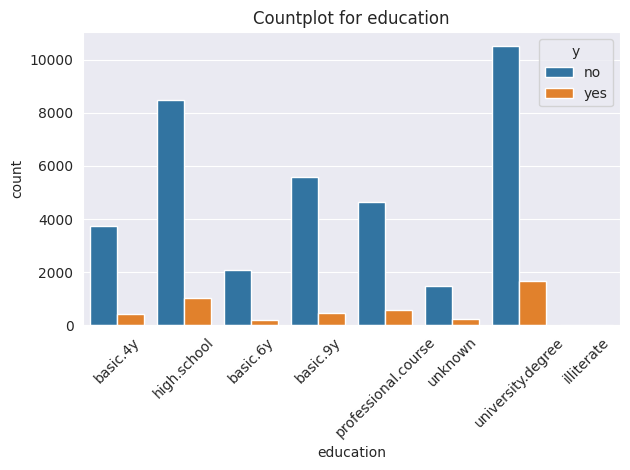

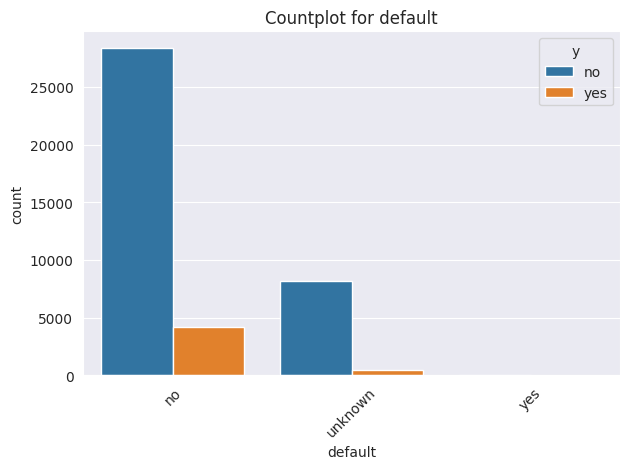

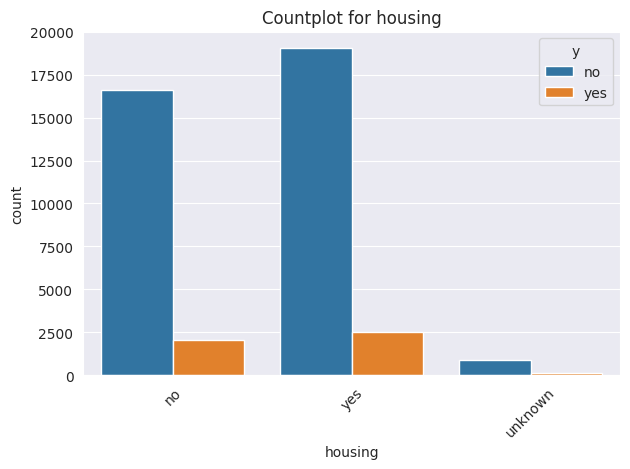

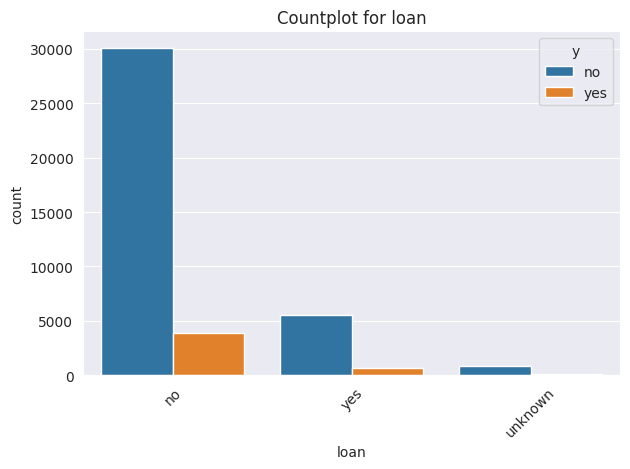

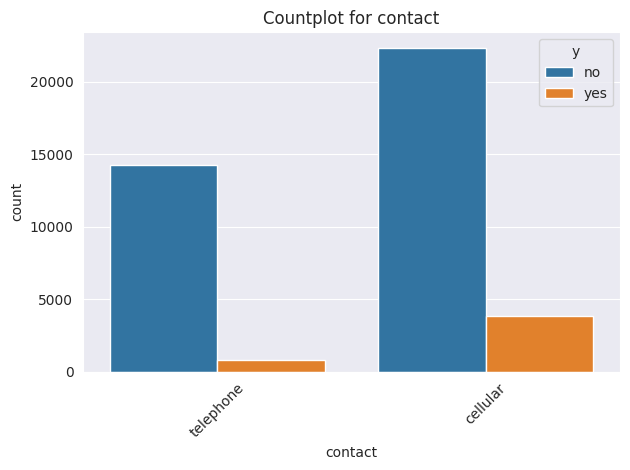

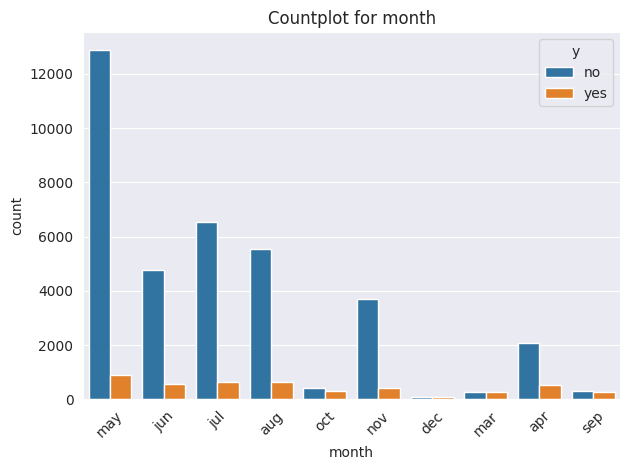

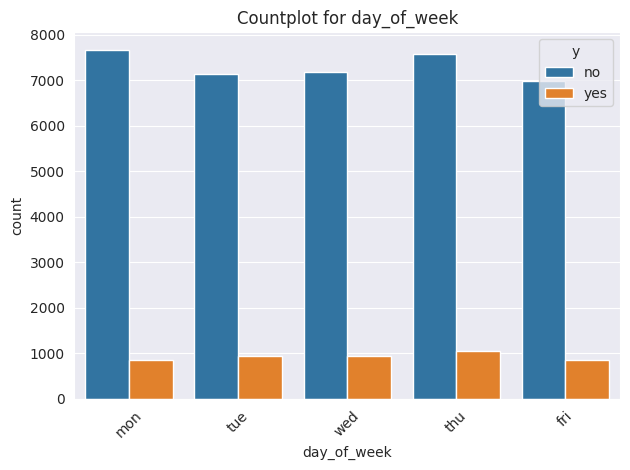

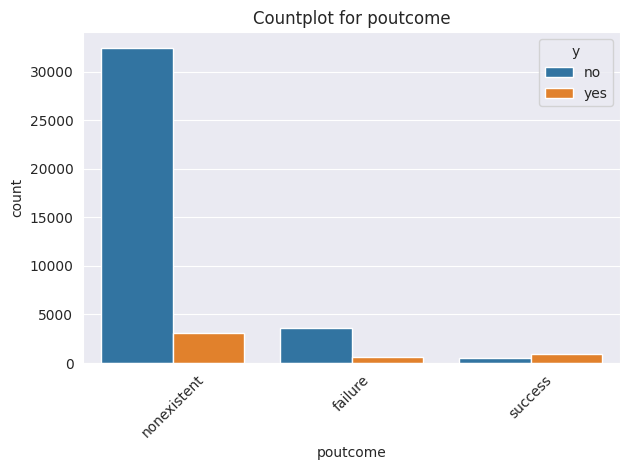

In [14]:
for c in categorical_cols:
  sns.countplot(data=df,x=c,hue='y')
  plt.xticks(rotation=45)
  plt.title(f'Countplot for {c}')
  plt.tight_layout()
  plt.show()

- видно, що переважають одружені клієнти(ті що оформили депозит, і ті що ні)




*   найбільше клієнтів з `university.degree`
*   невідомої категорії трохи так є, тому лишаємо як є - окремою категорією





*   якщо є прострочений кредит, то не беруть депозит






* можна помітити, що дні тижня коли проходила кампанія розподілена рівномірно
* найбільш активний місяць був травень


### Гіпотези


*   як було вказано в умові `duration` впливає на цільову змінну, що логічно бо якщо клієнт зацікавлений в депозиті буде більше питати
*   також на цільову змінну "негативно" вливає `nr.employed`, чим краща екноміка, тим менше людей хоче відкривтаи депозити-кредити
*   також якщо з клієнтом був попередній успішний досвід попередньої кампанії, він більш ймовірно і цього разу "включиться"




# Препроцесінг


### Перетворення цільової колнки у відповідні значення

In [15]:
df['target'] = (df["y"] == "yes").astype(int)

In [16]:
df = df.drop('duration',axis=1)

*викидаю змінну (пояснення було вище)*

## кодування колонок

#### `pdays`

In [17]:
df['previous_contact'] = (df["pdays"] != 999).astype(int)

In [18]:
df['pdays'].replace({999:np.nan},inplace=True)

#### `age`

<Axes: xlabel='age', ylabel='Count'>

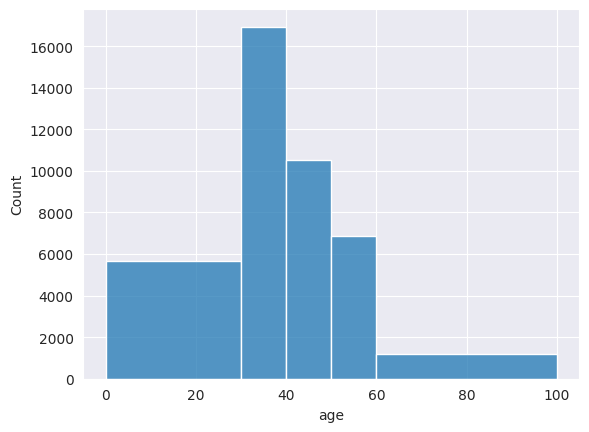

In [19]:
sns.histplot(data=df,x='age',bins=[0,30,40,50,60,100])

In [20]:
df['age_bin'] = pd.cut(df['age'],bins=[0,20,30,40,50,60,100], labels=['20-','21-30','31-40','41-50','51-60','60+'])

In [21]:
df.age_bin.value_counts()

,count
age_bin,
31-40,16385
41-50,10240
21-30,7243
51-60,6270
60+,910
20-,140


### Фільтруємо викиди

In [22]:
def outlier_range(dataset,column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    Min_value = (Q1 - 1.5 * IQR)
    Max_value = (Q3 + 1.5 * IQR)
    return Min_value,Max_value

In [23]:
for c in ['campaign','previous','cons.conf.idx']:
  print(outlier_range(df,c))
  low,up = outlier_range(df,c)
  df[c].clip(lower=low,upper=up,inplace=True)

(np.float64(-2.0), np.float64(6.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-52.150000000000006), np.float64(-26.949999999999992))


## split data

In [24]:
features_col = [c for c in df.columns if c!='y' and c!='target']

In [25]:
numeric_cols = [c for c in features_col if df[c].dtype != 'object'] #перезаписую колонки бо додались нові
categorical_cols = [c for c in features_col if df[c].dtype == 'object']

In [26]:
df.age_bin.dtype

CategoricalDtype(categories=['20-', '21-30', '31-40', '41-50', '51-60', '60+'], ordered=True, categories_dtype=object)

In [27]:
numeric_cols, categorical_cols

(['age',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed',
  'previous_contact',
  'age_bin'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'])

In [28]:
numeric_cols.pop()
categorical_cols.append('age_bin')

In [29]:
X = df.drop(['target','y'],axis=1)
Y = df['target']

In [30]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,previous_contact,age_bin
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,51-60
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,51-60
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,31-40
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,31-40
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,51-60


In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [32]:
X_train.shape, X_val.shape, X_test.shape

((28831, 21), (6178, 21), (6179, 21))

## pipeline

In [33]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=True))
])
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Вибір метрики

Для бінарної класифікації є багато варіантів метрик для оцінки якості моделей:

1. Accuracy - відпадає одразу, бо в нас дуже сильно переважає один клас
2. Recall - якщо потрібно не втрати потенційних клієнтів
3. Precision - якщо потрібно не втрачати час на тих хто і так відмовиться
4. F1-score - оскільки це гармонійне середнє між попередніми двома, покаже баланс між цими твердженнями
5. ROC-AUC - дасть змогу загально оцінити якість роботи моделі , як добре розділяє наш таргет


Буду використовувати останню для оцінки

In [132]:
def evaluate_model(model, X,y, model_name):
    '''
    calculates ROC-AUC, and plots the ROC curve.
    '''
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    roc_auc = roc_auc_score(y, y_proba)

    print(f"{model_name}")
    print(f"ROC-AUC:  {roc_auc:.4f}")

    # ROC-curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-curve")
    plt.legend()
    plt.show()

    return round(roc_auc,4)


In [133]:
results_compare = []

# Logistic Regression

In [35]:
model_log= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000,
                                      class_weight='balanced',
                                      n_jobs=-1,
                                      solver='saga'))
])

In [36]:
model_log.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'previous_contact']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome', 'age_bin'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, solver='saga'))])

Training (Logistic Regression)
ROC-AUC:  0.7923


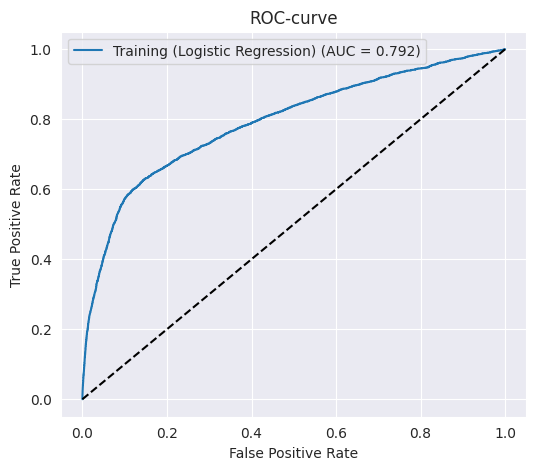

Validating (Logistic Regression)
ROC-AUC:  0.8034


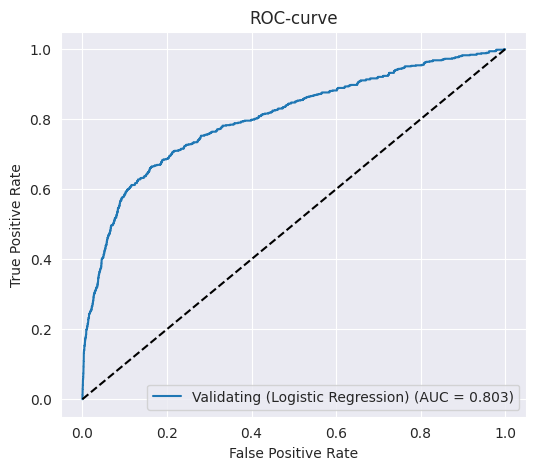

In [134]:
results_compare.append({'Model':"Logistic Regression",
                        'Hyperparams':[
                            'max_iter:1000',
                            'class_weight:balanced',
                            'n_jobs:-1',
                            'solver:saga'],
                        'AUR-ROC curve Train': evaluate_model(model_log,X_train,y_train,'Training (Logistic Regression)'),
                        'AUR-ROC curve Validate':evaluate_model(model_log,X_val,y_val,'Validating (Logistic Regression)')})

# KNN

In [38]:
model_knn= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=25))
])

In [40]:
model_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'previous_contact']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome', 'age_bin'])])),
                ('knn', KNeighborsClassifier(n_neighbors=25))])

Training (KNN)
ROC-AUC:  0.8495


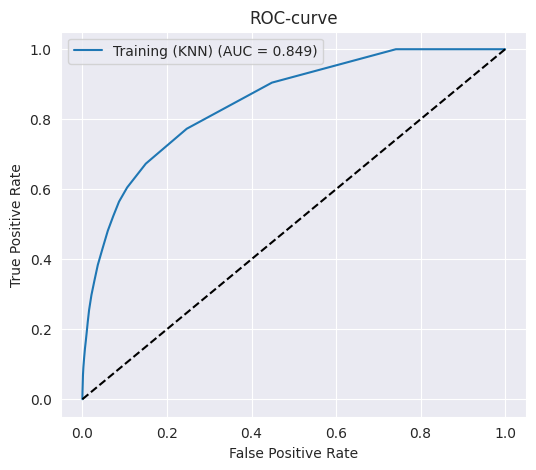

Validating (KNN)
ROC-AUC:  0.7836


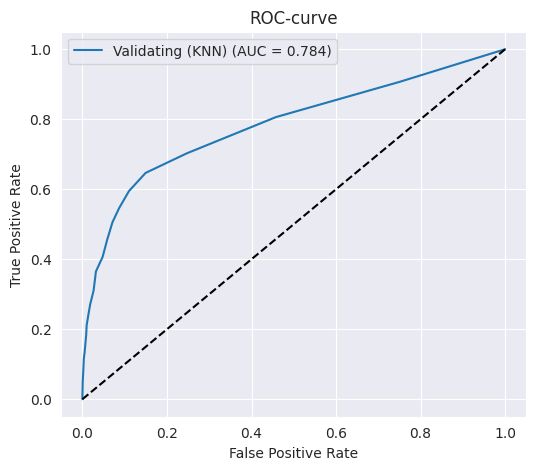

In [136]:
results_compare.append({'Model':"KNN",
                        'Hyperparams':[
                            'n_neighbors=25'],
                        'AUR-ROC curve Train': evaluate_model(model_knn,X_train,y_train,'Training (KNN)'),
                        'AUR-ROC curve Validate':evaluate_model(model_knn,X_val,y_val,'Validating (KNN)')})

# Decision Tree

In [97]:
model_dt= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(max_depth=7,max_leaf_nodes=20,random_state=42))
])

In [98]:
model_dt.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'previous_contact']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome', 'age_bin'])])),
                ('tree',
                 DecisionTreeClassifier(max_depth=7, max_leaf_nodes=20,
                                        min_samples_leaf=20,
                                        min_samples_split=50,
                                        random_state=42))])

Training (Tree)
ROC-AUC:  0.7867


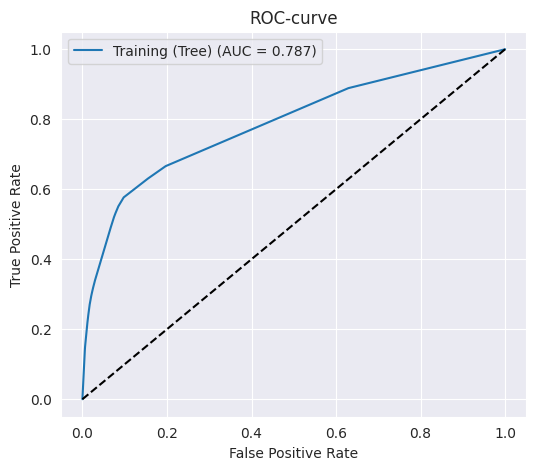

Validating (Tree)
ROC-AUC:  0.8034


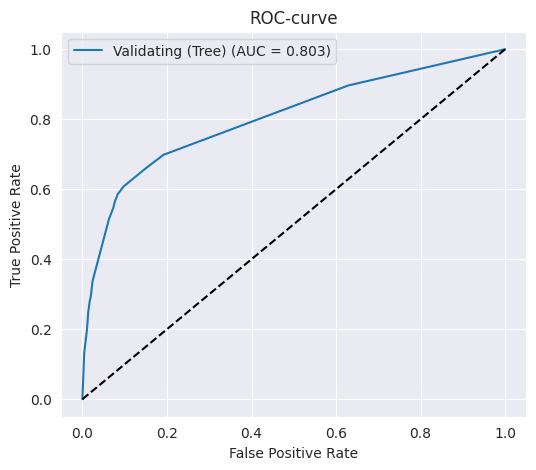

In [138]:
results_compare.append({'Model':"Decision Tree",
                        'Hyperparams':[
                            'max_depth=7',
                            'max_leaf_nodes=20',
                            'random_state=42'],
                        'AUR-ROC curve Train': evaluate_model(model_dt,X_train,y_train,'Training (Tree)'),
                        'AUR-ROC curve Validate':evaluate_model(model_dt,X_test,y_test,'Validating (Tree)')})

# XGBoost

In [110]:
model_xgb = Pipeline([
    ('preprocessor', preprocessor),
     ("clf", XGBClassifier(
         n_estimators=400,
         max_depth=4,
         learning_rate=0.05,
         subsample=0.9,
         colsample_bytree=0.8,
         reg_lambda=2.0,
         eval_metric='auc',
         tree_method='hist',
         random_state=42,
         n_jobs=-1
         ))
     ])

In [111]:
model_xgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'previous_contact']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

Training (XGBoost)
ROC-AUC:  0.8437


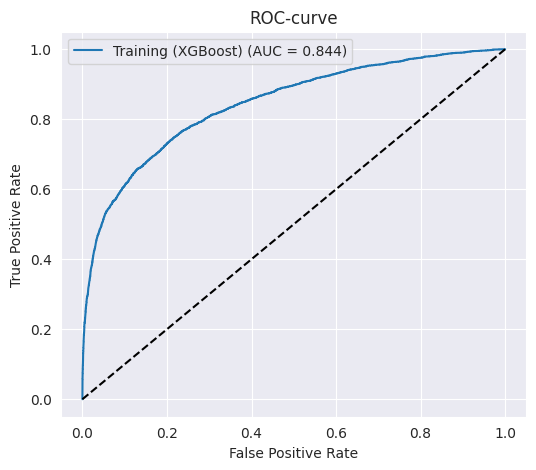

Validating (XGBoost)
ROC-AUC:  0.8088


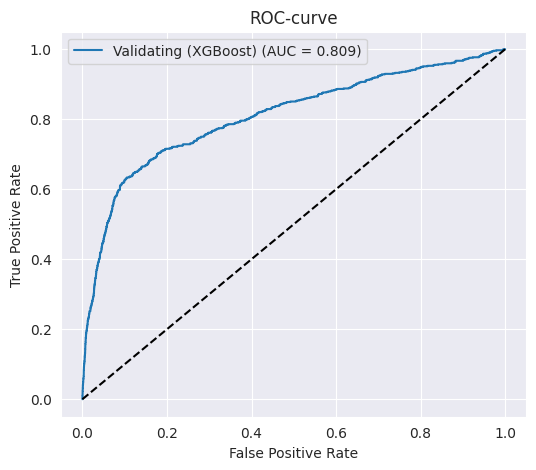

In [139]:
results_compare.append({'Model':"XGBoost",
                        'Hyperparams':[
                            'n_estimators=400',
                            'max_depth=4',
                            'learning_rate=0.05',
                            'subsample=0.9',
                            'colsample_bytree=0.8',
                            'reg_lambda=2.0',
                            'eval_metric=auc',
                            'tree_method=hist',
                            'random_state=42',
                            'n_jobs=-1'],
                        'AUR-ROC curve Train': evaluate_model(model_xgb,X_train,y_train,'Training (XGBoost)'),
                        'AUR-ROC curve Validate':evaluate_model(model_xgb,X_test,y_test,'Validating (XGBoost)')})

# Порівняння моделей

In [160]:
res_df = pd.DataFrame(results_compare)
#res_df.set_index('Model',inplace=True)
res_df

,Model,Hyperparams,AUR-ROC curve Train,AUR-ROC curve Validate
0,Logistic Regression,"[max_iter:1000, class_weight:balanced, n_jobs:...",0.7923,0.8034
1,KNN,[n_neighbors=25],0.8495,0.7836
2,Decision Tree,"[max_depth=7, max_leaf_nodes=20, random_state=42]",0.7867,0.8034
3,XGBoost,"[n_estimators=400, max_depth=4, learning_rate=...",0.8437,0.8088


1. Проста і швидка; можна додати регуляризацію (`C`, L1/L2) і ще попрацювати з гіперпараметрами.
2. Модель може дуже швидко перенавчитися. Тому на нових даних спрацьовує найгріше
3. Теж легко перенавчається, але легше контролювати; можна експериментувати з ансамблями.                  
4. Найкраща модель; можна ще тюнити гіперпараметри (RandomSearch, Hyperopt).   


# XGBoost Tunning

## RandomizedSearchCV

In [148]:
model_xgb_rs = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb_rs', XGBClassifier(
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ))
])

In [153]:
param_xgb_rs = {
    "xgb_rs__n_estimators": stats.randint(50, 1000),
    "xgb_rs__max_depth": stats.randint(3, 10),
    "xgb_rs__learning_rate": stats.loguniform(1e-3, 1e-1),
    "xgb_rs__subsample": stats.uniform(0.5, 0.5),
    "xgb_rs__colsample_bytree": stats.uniform(0.5, 0.5),
    "xgb_rs__gamma": stats.loguniform(1e-3, 1.0)
}

In [154]:
search = RandomizedSearchCV(
    model_xgb_rs,
    param_distributions=param_xgb_rs,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'emp.var.rate',
                                                                                'cons.price.idx',
                                                                                'cons.conf.idx',
                                                                                'euribor3m',
                                                                                'nr.employed',
                                                                                'previous_contact']),
                                                                              ('cat',
                                                                               Pipeline(steps=...
                                        'xgb_rs__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7abb02b9c290>,
                                        'xgb_rs__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7abb02b9e060>,
                                        'xgb_rs__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7abb02b9cd10>,
                                        'xgb_rs__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7abb02b9d5b0>},
                   random_state=42, scoring='roc_auc', verbose=1)

In [155]:
best_xgb_rs_param = search.best_params_
best_xgb_rs_param

{'xgb_rs__colsample_bytree': np.float64(0.9402339195076288),
 'xgb_rs__gamma': np.float64(0.07465555774745708),
 'xgb_rs__learning_rate': np.float64(0.003901821268272624),
 'xgb_rs__max_depth': 7,
 'xgb_rs__n_estimators': 695,
 'xgb_rs__subsample': np.float64(0.7282672852414551)}

In [156]:
best_xgb_rs_model = search.best_estimator_

In [157]:
search.best_score_

np.float64(0.7962365421155475)

Validating (XGBoost RandomizedSearchCV)
ROC-AUC:  0.8175


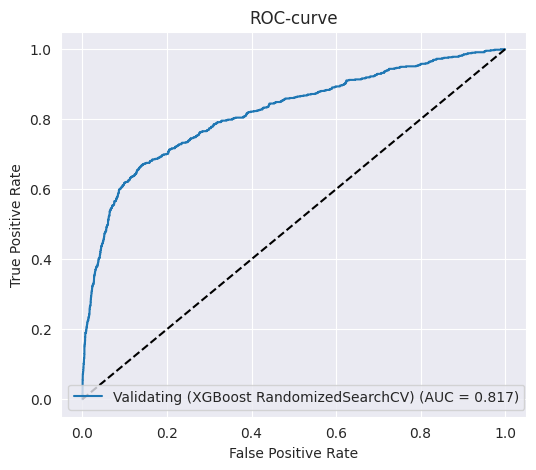

In [161]:
res_df.loc[len(res_df)] = ["XGBoost RandomizedSearchCV", [
    'xgb_rs__colsample_bytree:0.940',
    'xgb_rs__gamma:0.075',
    'xgb_rs__learning_rate:0.004',
    'xgb_rs__max_depth: 7',
    'xgb_rs__n_estimators: 695',
    'xgb_rs__subsample:0.728'],
                          0.7962,
                          evaluate_model(best_xgb_rs_model,X_val,y_val,'Validating (XGBoost RandomizedSearchCV)')]

## Hyperopt

In [172]:
def objective(params):
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(
                    n_estimators=int(params['n_estimators']),
                    learning_rate=params['learning_rate'],
                    max_depth=int(params['max_depth']),
                    min_child_weight=params['min_child_weight'],
                    subsample=params['subsample'],
                    colsample_bytree=params['colsample_bytree'],
                    gamma=params['gamma'],
                    reg_alpha=params['reg_alpha'],
                    reg_lambda=params['reg_lambda'],
                    eval_metric='auc'))
        ])

    clf.fit(X_train,y_train)

    pred_prob = clf.predict_proba(X_val)
    auroc = roc_auc_score(y_val, pred_prob[:,1])

    return {'loss': -auroc, 'status': STATUS_OK}

In [173]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

In [174]:
trials = Trials()
best_hopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

best_hopt['n_estimators'] = int(best_hopt['n_estimators'])
best_hopt['max_depth'] = int(best_hopt['max_depth'])
best_hopt['min_child_weight'] = int(best_hopt['min_child_weight'])

100%|██████████| 50/50 [01:42<00:00,  2.06s/trial, best loss: -0.8159555357764388]


In [175]:
final_xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBClassifier(
        n_estimators=int(best_hopt['n_estimators']),
        learning_rate=float(best_hopt['learning_rate']),
        max_depth=int(best_hopt['max_depth']),
        min_child_weight=float(best_hopt['min_child_weight']),
        subsample=float(best_hopt['subsample']),
        colsample_bytree=float(best_hopt['colsample_bytree']),
        gamma=float(best_hopt['gamma']),
        reg_alpha=float(best_hopt['reg_alpha']),
        reg_lambda=float(best_hopt['reg_lambda']),
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ))
])
final_xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'previous_contact']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy...
                               gamma=0.31130319657045413, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.14183145408977926, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=8.0,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=175, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [178]:
best_hopt

{'colsample_bytree': np.float64(0.8177317544833),
 'gamma': np.float64(0.31130319657045413),
 'learning_rate': np.float64(0.14183145408977926),
 'max_depth': 3,
 'min_child_weight': 8,
 'n_estimators': 175,
 'reg_alpha': np.float64(0.9126871042132261),
 'reg_lambda': np.float64(0.7379442051668379),
 'subsample': np.float64(0.6097190971193565)}

Training (XGBoost Hyperopt)
ROC-AUC:  0.8235


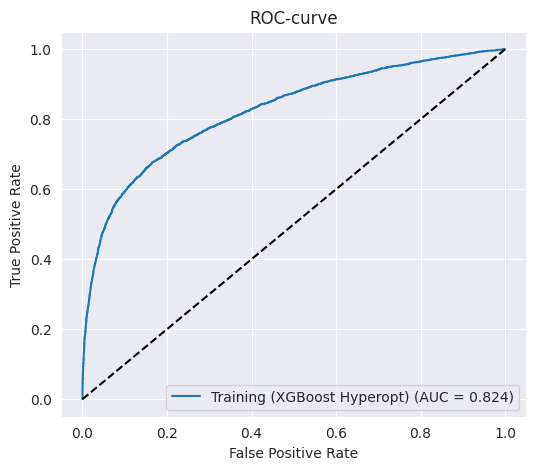

Validating (XGBoost Hyperopt)
ROC-AUC:  0.8117


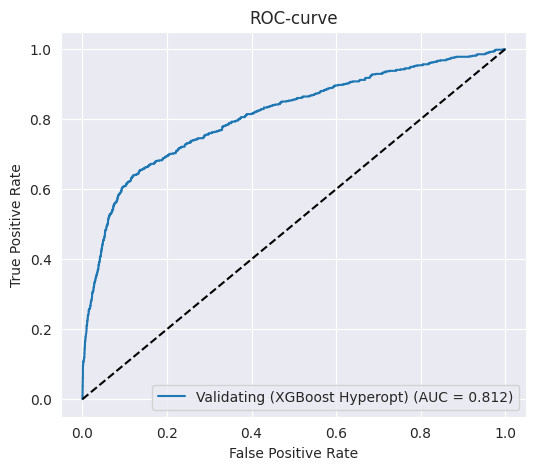

In [194]:
res_df.loc[len(res_df)] = ["XGBoost Hyperopt", [
    'colsample_bytree:0.818',
    'gamma:0.311',
    'learning_rate:0.142',
    'max_depth: 3',
    'min_child_weight: 8',
    'n_estimators: 175',
    'reg_alpha:0.913',
    'reg_lambda:0.738',
    'subsample:0.610'],
                          evaluate_model(final_xgb_model,X_train,y_train,'Training (XGBoost Hyperopt)'),
                          evaluate_model(final_xgb_model,X_val,y_val,'Validating (XGBoost Hyperopt)')]

# Важливість ознак

In [195]:
res_df

,Model,Hyperparams,AUR-ROC curve Train,AUR-ROC curve Validate
0,Logistic Regression,"[max_iter:1000, class_weight:balanced, n_jobs:...",0.7923,0.8034
1,KNN,[n_neighbors=25],0.8495,0.7836
2,Decision Tree,"[max_depth=7, max_leaf_nodes=20, random_state=42]",0.7867,0.8034
3,XGBoost,"[n_estimators=400, max_depth=4, learning_rate=...",0.8437,0.8088
4,XGBoost RandomizedSearchCV,"[xgb_rs__colsample_bytree:0.940, xgb_rs__gamma...",0.7962,0.8175
5,XGBoost Hyperopt,"[colsample_bytree:0.818, gamma:0.311, learning...",0.8235,0.8117


Найкраще тут себе показала модель XGBoost with RandomizedSearchCV, тому на цій моделі запускаю преедбачення на тестувих даних

Testing (XGBoost RandomizedSearchCV)
ROC-AUC:  0.8102


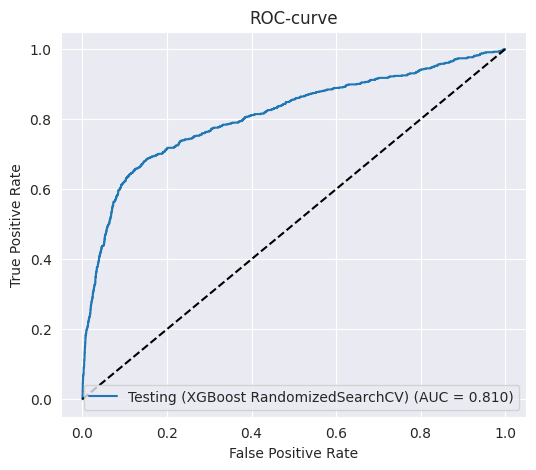

np.float64(0.8102)

In [200]:
evaluate_model(best_xgb_rs_model,X_test,y_test,'Testing (XGBoost RandomizedSearchCV)')

In [202]:
xgb_model = best_xgb_rs_model.named_steps["xgb_rs"]
feature_names = best_xgb_rs_model.named_steps["preprocessor"].get_feature_names_out()
importances = xgb_model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp.head(10)

,feature,importance
8,num__nr.employed,0.450721
9,num__previous_contact,0.051091
62,cat__poutcome_success,0.040493
6,num__cons.conf.idx,0.032533
51,cat__month_may,0.030797
4,num__emp.var.rate,0.029326
53,cat__month_oct,0.025864
7,num__euribor3m,0.015331
43,cat__contact_cellular,0.012527
44,cat__contact_telephone,0.011610


- `nr.employed`  – якщо більше людей працевлаштовані(більш впевнені в майбутньому), то цілком ймовірно що менше погоджуються на депозит

- `previous_contact` – якщо з клієнтом вже кілька разів спілкувались, ймовірність відкриття депозиту зростає

- `poutcome_success` – якщо раніше клієнт вже відкривав депозити, він з більшою ймовірністю погодиться знову.

і так впринципі всі ознаки є логічні, лише питання до ознак місяця (`month_may` і `month_oct`) швидше за все це співпало що саме активність цієі конктреної кампанії була в ці місяці, на інші кампанії не вплине

# SHAP

In [217]:
explainer = shap.KernelExplainer(
    lambda x: best_xgb_rs_model.predict(pd.DataFrame(x, columns=X.columns)),
    X_train[:500])
shap_values = explainer.shap_values(pd.DataFrame(X_test[:30], columns=X.columns))

  0%|          | 0/30 [00:00<?, ?it/s]

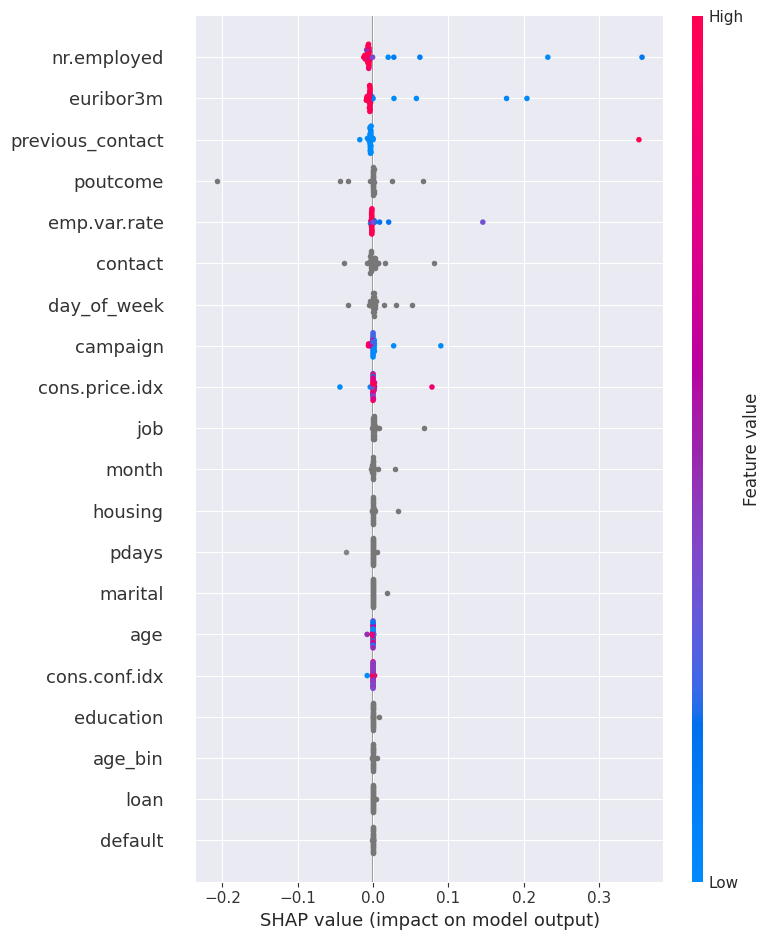

In [218]:
shap.summary_plot(shap_values, X_test[:30])

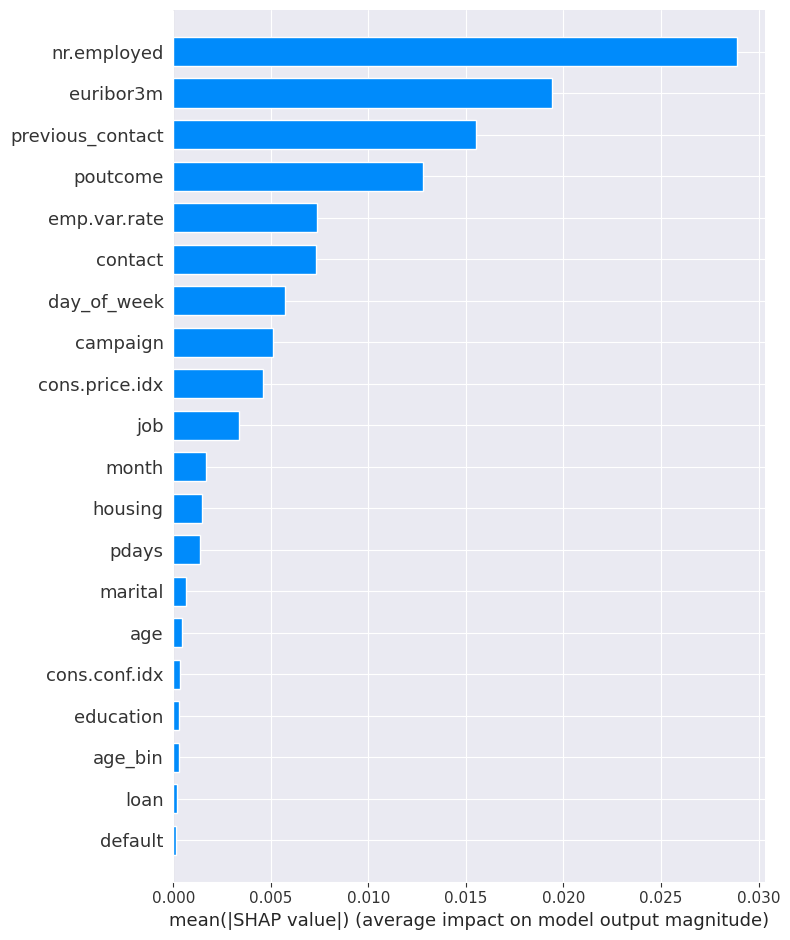

In [219]:
shap.summary_plot(shap_values, X_test[:30],plot_type='bar')

In [220]:
i = 40

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[1],
    X_test.iloc[i]
)

З графіків вище, можна зрозуміти що найбільший влив мають економічні показники і чим економіка стабільніша, тим менше потреба в депозитах

Тако важливу роль відіграють чинники співпраці з клієнтами - вони дають більший шанс на позитивний вихід кампанії

# Аналіз помилок

In [234]:
y_proba = best_xgb_rs_model.predict_proba(X_test)[:, 1]

In [235]:
y_pred = best_xgb_rs_model.predict(X_test)

In [236]:
err_df = X_test.copy()
err_df['y_true'] = y_test.copy()
err_df['proba'] = y_proba
err_df['y_pred'] = y_pred

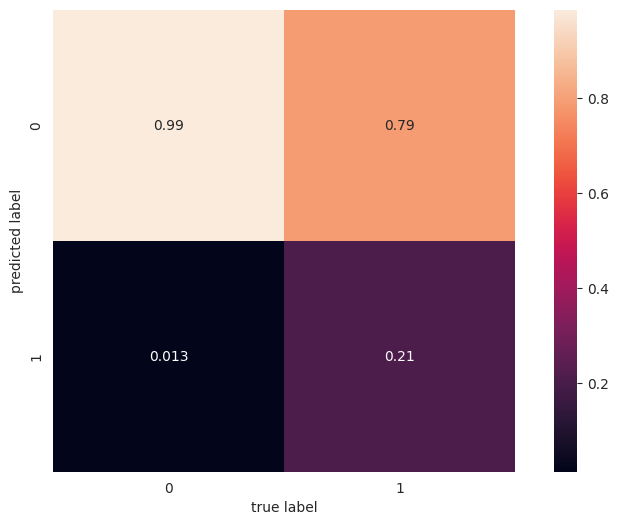

In [245]:
mat =confusion_matrix(y_test, y_pred,normalize='true')
plt.figure(figsize=(10,6))
sns.heatmap(mat.T, square=True, annot=True,  cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

Через дуже не збалансовані дані, модель гарно справляється з класифікуванням хто не відкриє депозит, але при тому реально тих хто відкриє часто класифікує як "не потенціний клієнт"

тому можна спробувати зараз встановити threshold не 0.5, а інший - що можливо покращить якість передбачення

In [246]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [248]:
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

np.float32(0.10047755)

In [249]:
y_pred_opt = (y_proba >= optimal_threshold).astype(int)

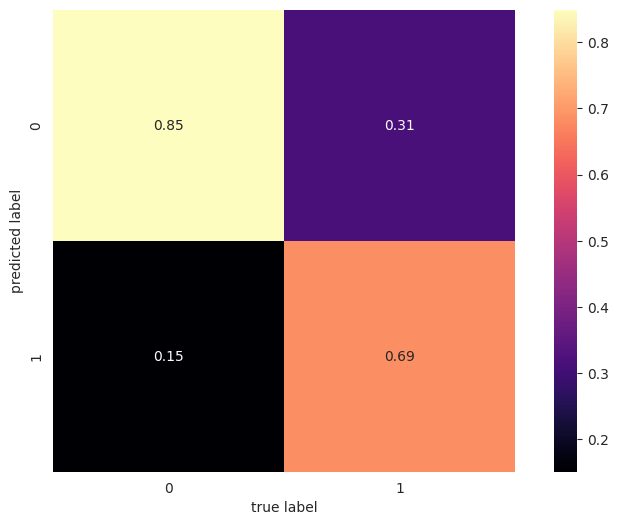

In [250]:
mat =confusion_matrix(y_test, y_pred_opt,normalize='true')
plt.figure(figsize=(10,6))
sns.heatmap(mat.T, square=True, annot=True,  cbar=True,cmap="magma")
plt.xlabel('true label')
plt.ylabel('predicted label');

Тепер ситуація краща, бо розпінаємо 70% клієнтів хто відкрив депозит. Хоч і впав трошки відсоток тих хто не відкриє, але все ще хороший результат - 85%


Щоб покращити модель, одним з рішень може бути семплінг - щоб власне вирівняти той дисбаланс класів
Також би спробувала ще ансамблі моделей, LightGBM
І ще попроацювати над препроцесінгом даних можливо